In [35]:
#!pip install bertopic[vision] datasets scikit-learn pandas seaborn matplotlib tqdm transformers torch sentence-transformers

import pandas as pd
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import requests
from tqdm.notebook import tqdm
from PIL import Image, UnidentifiedImageError
from datasets import load_dataset

from bertopic import BERTopic
from bertopic.backend import MultiModalBackend
from bertopic.representation import VisualRepresentation

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPVisionModel

# static vars
IMAGE_ROOT = "/content/TextCaps/images"
CAPTION_FILE = "/content/TextCaps/captions.csv"
n_samples = 6000

print("Starting Data Preparation and Download..")

ds = load_dataset("lmms-lab/TextCaps", split="train")
df = ds.to_pandas()

print("Extracting captions...")
def extract_first_caption_robustly(ref_strs):
    """Safely converts input to a list and returns the first element, or None."""
    try:
        ref_list = list(ref_strs)
        if len(ref_list) > 0 and isinstance(ref_list[0], str):
            return ref_list[0]
        else:
            return None
    except:
        return None

df['caption'] = df['reference_strs'].apply(extract_first_caption_robustly)

# Sample images (and corresponding captions)
df = df.sample(n=n_samples, random_state=42).reset_index(drop=True)

# Create image folder
os.makedirs(IMAGE_ROOT, exist_ok=True)

# Download images
print("Downloading and verifying images..")
valid_image_count = 0
for idx, row in tqdm(df.iterrows(), total=len(df)):
    url = row['flickr_300k_url']
    img_name = row['image_name'] + ".jpg"
    img_path = os.path.join(IMAGE_ROOT, img_name)

    if os.path.exists(img_path):
        valid_image_count += 1
        continue

    try:
        r = requests.get(url, timeout=5)
        r.raise_for_status()
        with open(img_path, "wb") as f:
            f.write(r.content)

        try:
            Image.open(img_path).verify()
            valid_image_count += 1
        except:
            os.remove(img_path)

    except:
        continue

print(f"Download completed. Total valid images: {valid_image_count}")

# Save captions (only rows with valid captions)
caption_df = df[['image_name', 'caption']].dropna(subset=['caption'])
caption_df.to_csv(CAPTION_FILE, index=False)
print(f"5. Captions saved successfully to {CAPTION_FILE}. Total saved: {len(caption_df)}")

Starting Data Preparation and Download..
Extracting captions...


  0%|          | 0/6000 [00:00<?, ?it/s]

Download completed. Total valid images: 5164
5. Captions saved successfully to /content/TextCaps/captions.csv. Total saved: 6000


In [36]:
def topic_miner(df: pd.DataFrame, documents: list, image_paths: list) -> pd.DataFrame:
    """
    Reads the dataset, uses BERTopic to identify multimodal topics,
    and labels each image with its assigned topic.
    """
    print("Starting Multimodal Topic Mining with BERTopic..")

    # Uses CLIP to create aligned image and text embeddings.
    embedding_model = MultiModalBackend("clip-ViT-B-32", batch_size=32)

    # Define representation model
    representation_model = {
        "Visual_Aspect": VisualRepresentation()
    }

    # Initialize and Fit BERTopic
    topic_model = BERTopic(
        embedding_model=embedding_model,
        representation_model=representation_model,
        min_topic_size=50,
        verbose=True
    )

    # Pass both documents (captions) and image paths for multimodal clustering
    topics, _ = topic_model.fit_transform(documents=documents, images=image_paths)

    print(f"\nSuccessfully identified {topic_model.get_topic_info().shape[0] - 1} topics (excluding -1 outlier topic).")
    print("Top 5 Topics:")
    print(topic_model.get_topic_info().head())

    # 4. Label each image with the assigned topic
    df['topic_label'] = topics
    return df

In [37]:
def get_multimodal_features(df: pd.DataFrame):
    """
    Extracts and combines image (CLIP ViT) and text (Sentence-BERT) embeddings.
    """
    print("Initializing CLIP and Sentence Transformer models..")

    # Text Encoder (Sentence Transformer)
    text_model = SentenceTransformer('all-MiniLM-L6-v2')
    text_embeddings = text_model.encode(df['caption'].tolist(), show_progress_bar=True)

    # Image Encoder (CLIP Vision Transformer)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

    image_embeddings = []
    batch_size = 64
    image_paths = df['image_path'].tolist()

    print(f"1. Extracting image features on {device}...")

    # Process images in batches
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Image Encoding"):
        batch_paths = image_paths[i:i + batch_size]
        try:
            batch_images = [Image.open(path).convert("RGB") for path in batch_paths]
        except Exception:
            continue

        inputs = processor(images=batch_images, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = vision_model(**inputs)
            # Use the pooled output (CLS token embedding)
            batch_features = outputs.pooler_output.cpu().numpy()

        image_embeddings.append(batch_features)

    image_embeddings = np.concatenate(image_embeddings, axis=0)

    # This creates the full multimodal feature vector X (combines features)
    X = np.concatenate([text_embeddings, image_embeddings], axis=1)

    return X, text_embeddings.shape[1], image_embeddings.shape[1]

In [38]:
def predict(df_labeled: pd.DataFrame) -> np.ndarray:
    """
    Accepts the labeled dataset, trains the best possible classifier (Linear SVC
    with Multimodal Features) to predict the BERTopic labels, and returns the
    Confusion Matrix.
    """
    print("\nStarting Multimodal Classification (Best Model Attempt)..")

    # Filter out the BERTopic outlier topic (-1)
    df_filtered = df_labeled[df_labeled['topic_label'] != -1].copy().reset_index(drop=True)

    if len(df_filtered) < 100:
        raise ValueError("Not enough samples after filtering out outliers for training.")

    # Multimodal Feature Extraction
    X, text_dim, image_dim = get_multimodal_features(df_filtered)
    y = df_filtered['topic_label'].values

    print(f"Features Combined! Total feature dimensions: {X.shape[1]}")

    # Split the dataset (70-30)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    print("Data split completed (70% Train, 30% Test).")

    # Train the Classifier (Linear SVM for high-dimensional embedding data)
    print("Training the Best Model Classifier..")

    classifier_pipeline = Pipeline([
        ('scaler', StandardScaler()), # Normalize features
        ('svc', SVC(
            kernel='linear',      # Highly effective for embedding vectors
            C=1.0,                # Regularization parameter
            random_state=42,
            max_iter=5000
        ))
    ])

    classifier_pipeline.fit(X_train, y_train)
    accuracy = classifier_pipeline.score(X_test, y_test)
    print(f"Test Accuracy (Linear SVM): {accuracy:.4f}")

    # Generate Confusion Matrix
    y_pred = classifier_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Visualization
    topic_labels = [f"Topic {t}" for t in np.unique(y)]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=topic_labels)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title(f"Confusion Matrix (Accuracy: {accuracy:.4f})")
    plt.show()

    return cm

Total valid image-caption pairs for modeling (FINAL COUNT): 5164

  STEP 1: RUNNING topic_miner()
Starting Multimodal Topic Mining with BERTopic..


2025-11-29 09:37:15,260 - BERTopic - Embedding - Transforming documents to embeddings.
100%|██████████| 162/162 [00:58<00:00,  2.76it/s]
2025-11-29 09:38:18,288 - BERTopic - Embedding - Completed ✓
2025-11-29 09:38:18,289 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-29 09:38:22,757 - BERTopic - Dimensionality - Completed ✓
2025-11-29 09:38:22,759 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-29 09:38:22,954 - BERTopic - Cluster - Completed ✓
2025-11-29 09:38:22,958 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 18/18 [00:01<00:00, 15.16it/s]
2025-11-29 09:38:24,314 - BERTopic - Representation - Completed ✓



Successfully identified 17 topics (excluding -1 outlier topic).
Top 5 Topics:
   Topic  Count                               Name  \
0     -1    602                   -1_of_the_and_on   
1      0    883                0_book_the_of_books   
2      1    880      1_wearing_baseball_player_the   
3      2    793             2_sign_the_street_that   
4      3    445  3_computer_screen_keyboard_laptop   

                                      Representation  \
0  [of, the, and, on, with, is, in, plate, that, ...   
1  [book, the, of, books, poster, and, page, is, ...   
2  [wearing, baseball, player, the, number, shirt...   
3  [sign, the, street, that, on, with, and, for, ...   
4  [computer, screen, keyboard, laptop, with, mon...   

                                       Visual_Aspect  \
0  <PIL.Image.Image image mode=RGB size=654x600 a...   
1  <PIL.Image.Image image mode=RGB size=464x600 a...   
2  <PIL.Image.Image image mode=RGB size=608x600 a...   
3  <PIL.Image.Image image mode=RGB 

Batches:   0%|          | 0/143 [00:00<?, ?it/s]

1. Extracting image features on cuda...


Image Encoding:   0%|          | 0/72 [00:00<?, ?it/s]

Features Combined! Total feature dimensions: 1152
Data split completed (70% Train, 30% Test).
Training the Best Model Classifier..
Test Accuracy (Linear SVM): 0.9372


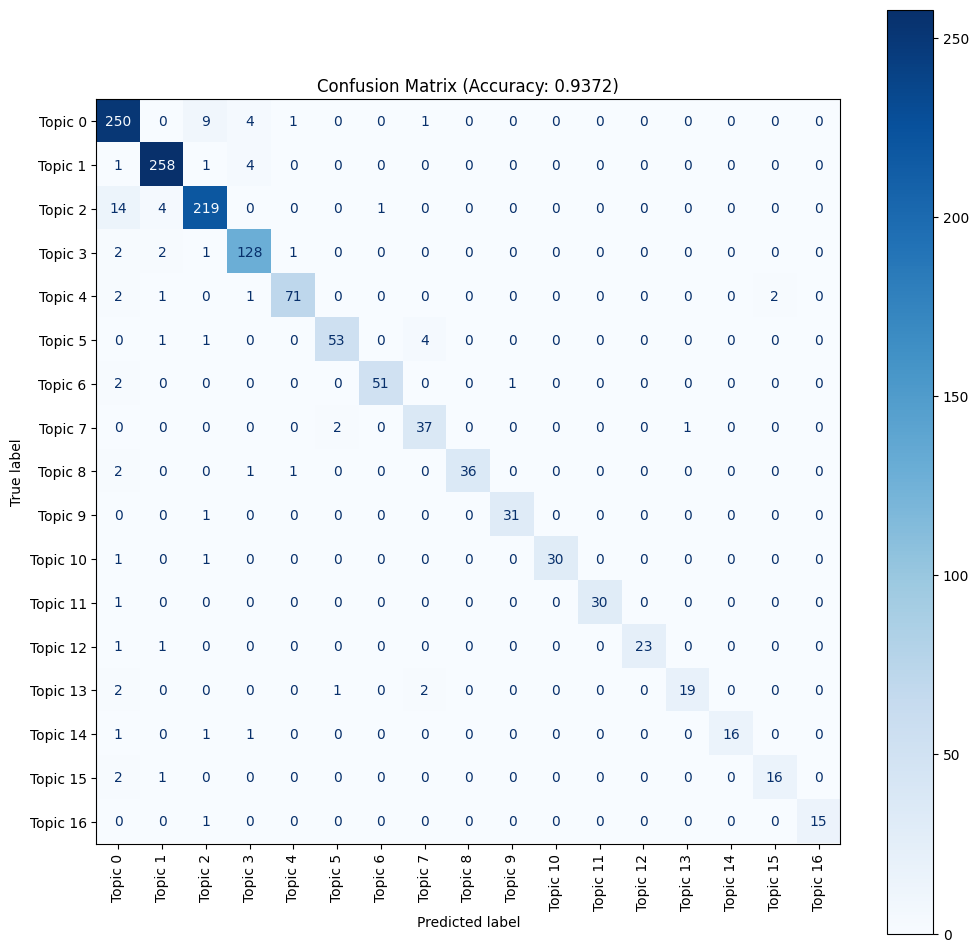

The Confusion Matrix (NumPy Array) is:
[[250   0   9   4   1   0   0   1   0   0   0   0   0   0   0   0   0]
 [  1 258   1   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 14   4 219   0   0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  2   2   1 128   1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   1   0   1  71   0   0   0   0   0   0   0   0   0   0   2   0]
 [  0   1   1   0   0  53   0   4   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0  51   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0   0   2   0  37   0   0   0   0   0   1   0   0   0]
 [  2   0   0   1   1   0   0   0  36   0   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0   0   0  31   0   0   0   0   0   0   0]
 [  1   0   1   0   0   0   0   0   0   0  30   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0  30   0   0   0   0   0]
 [  1   1   0   0   0   0   0   0   0   0   0   0  23   0   0   0   0]
 [  2   0   0   0   0   1   0   2   0 

In [39]:

IMAGE_ROOT = "/content/TextCaps/images"
CAPTION_FILE = "/content/TextCaps/captions.csv"

df_captions = pd.read_csv(CAPTION_FILE)
df_captions['image_path'] = df_captions['image_name'].apply(lambda x: os.path.join(IMAGE_ROOT, x + ".jpg"))

# Filter to include only rows that have a valid image AND a valid caption
image_files = set(os.listdir(IMAGE_ROOT))
df_labeled = df_captions[
    df_captions['image_name'].apply(lambda x: x + ".jpg" in image_files) &
    df_captions['caption'].notna()
].reset_index(drop=True)

documents = df_labeled['caption'].tolist()
image_paths = df_labeled['image_path'].tolist()

print(f"Total valid image-caption pairs for modeling (FINAL COUNT): {len(df_labeled)}\n")


# execution

# Topic Mining
print("==============================================")
print("  STEP 1: RUNNING topic_miner()")
print("==============================================")
df_labeled_with_topics = topic_miner(df_labeled.copy(), documents, image_paths)


# Step B: Classification and Evaluation
print("\n==============================================")
print("  STEP 2: RUNNING predict()")
print("==============================================")
confusion_matrix_result = predict(df_labeled_with_topics)

print("The Confusion Matrix (NumPy Array) is:")
print(confusion_matrix_result)